In [1]:
from pymongo import MongoClient
from stm import atomically
from concurrent.futures import ThreadPoolExecutor

import time
import os
import matplotlib.pyplot as plt
import math

Створення конектора до серверу з базою даних **mongodb**.

In [2]:
MONGODB_URI = os.environ.get("MONGODB_URI", "mongodb://localhost:27017")
client = MongoClient(MONGODB_URI, username="root", password="root")
db = client.cafes
cafes = db.cafes

Функції для роботи з базою даних. Дві основні операції: вибір(select) та оновлення(update).

In [3]:
def change_rating(from_cafe, to_cafe, amount):
    @atomically
    def _():
        cafe = cafes.find_one({'name': from_cafe})

        cafes.update_one({'name': from_cafe}, {'$inc': {'rating': -amount}})
        cafes.update_one({'name': to_cafe}, {'$inc': {'rating': amount}})

def increase_rating(to_cafe, amount):
    @atomically
    def _():
        cafes.update_one({'name': to_cafe}, {'$inc': {'rating': amount}})

Функція для запуску futures.

In [4]:
def run_transactions(num_threads=50, num_transactions=100):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for _ in range(num_transactions):
            futures.append(executor.submit(lambda: change_rating("Starbucks", "Cafe Coffee Day", 0.01)))
            futures.append(executor.submit(lambda: change_rating("Cafe Coffee Day", "Dunkin Donuts", 0.01)))
            futures.append(executor.submit(lambda: change_rating("Dunkin Donuts", "Tim Hortons", 0.01)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: increase_rating("Starbucks", 0.01)))
            futures.append(executor.submit(lambda: increase_rating("Cafe Coffee Day", 0.01)))

        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Основний цикл роботи усієї програми.

In [5]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions()
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 0.9324 seconds
Completed 150.0 transactions in 2 iteration in 1.2064 seconds
Completed 150.0 transactions in 3 iteration in 0.7129 seconds
Completed 150.0 transactions in 4 iteration in 0.6378 seconds
Completed 150.0 transactions in 5 iteration in 0.6437 seconds
Completed 150.0 transactions in 6 iteration in 0.6289 seconds
Completed 150.0 transactions in 7 iteration in 0.5963 seconds
Completed 150.0 transactions in 8 iteration in 0.7908 seconds
Completed 150.0 transactions in 9 iteration in 0.6221 seconds
Completed 150.0 transactions in 10 iteration in 0.7956 seconds
Completed 150.0 transactions in 11 iteration in 0.6971 seconds
Completed 150.0 transactions in 12 iteration in 0.6639 seconds
Completed 150.0 transactions in 13 iteration in 0.6315 seconds
Completed 150.0 transactions in 14 iteration in 0.5935 seconds
Completed 150.0 transactions in 15 iteration in 0.6101 seconds
Completed 150.0 transactions in 16 iteration in 0.6769 seconds
C

Побудова графіка роботи програми.

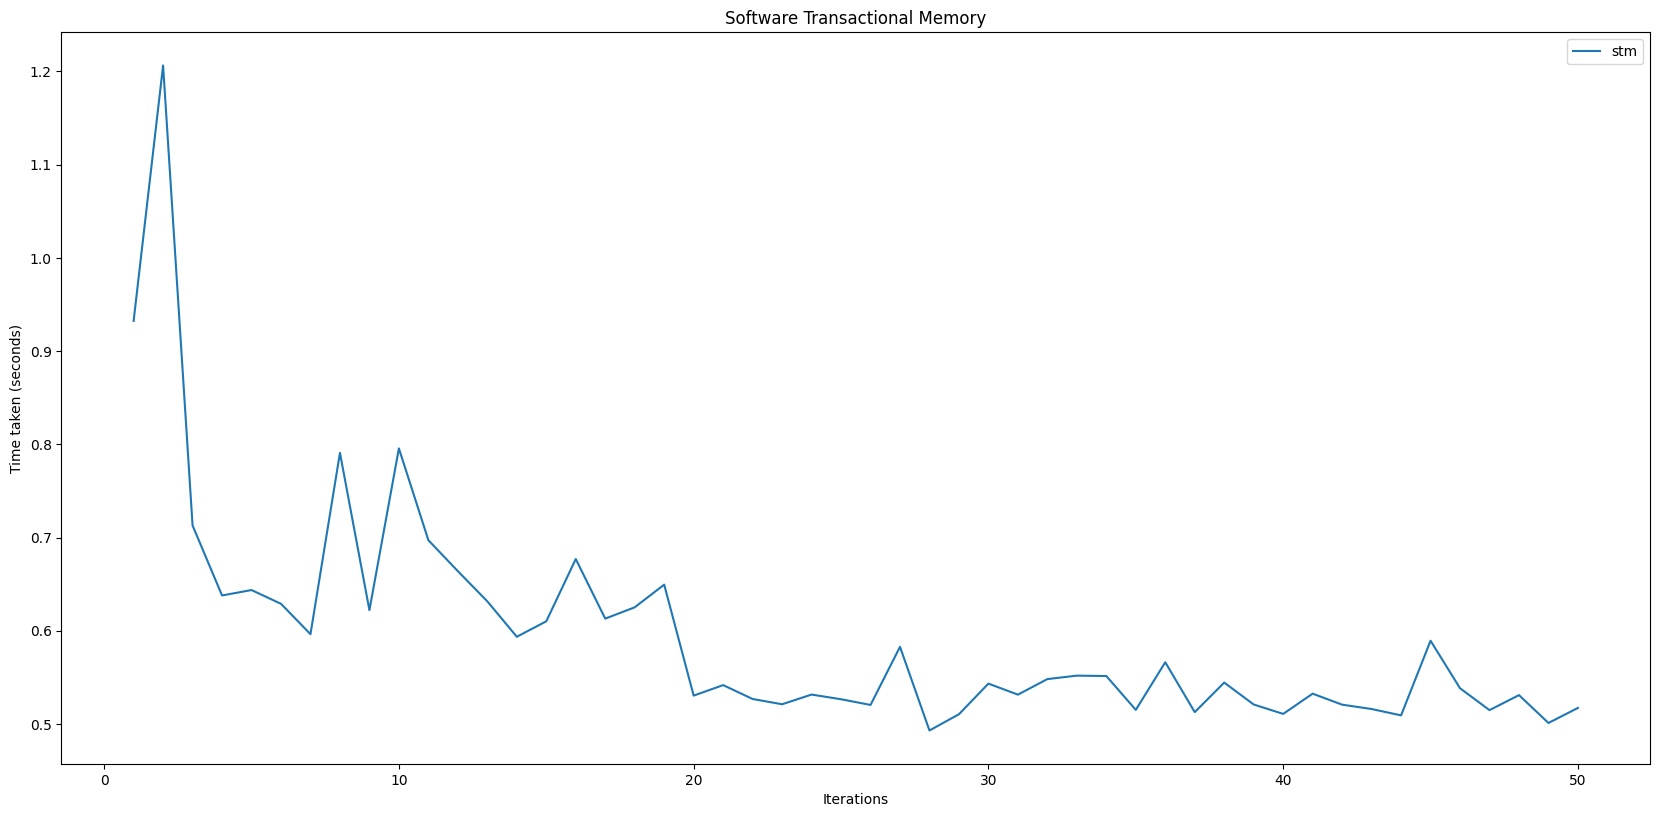

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='stm')
ax.set_xlabel('Iterations')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('Software Transactional Memory')
ax.legend()
plt.show()